# Imports

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
# Read data
df = pd.read_csv('/kaggle/input/ibm-classification-feature-engineering/all_data.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

In [3]:
df.head(5)

,Date,Symbol,Volume,Home Price Index,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,...,Adj Close 7-Day Upper Bollinger Band Differenced,Adj Close 7-Day Lower Bollinger Band Differenced,True Range Differenced,True Range 26-Day SMA Differenced,Adj Close Differenced,Close Differenced,High Differenced,Low Differenced,Open Differenced,S&P500 Differenced
0,2014-09-04,14,3961600.0,147.395,0,0,0,0,1,0,...,-0.070978,0.123789,0.055607,0.023318,-0.352859,-0.629997,0.049999,-0.549999,-0.320000,-3.07
1,2014-09-04,262,2420000.0,147.395,0,0,0,0,1,0,...,0.000704,-0.003135,-0.366959,0.033772,-0.509972,-0.599998,-0.180000,-0.930000,-0.720001,-3.07
2,2014-09-04,105,8412100.0,147.395,0,0,0,0,0,0,...,-0.044783,-0.182445,-0.042297,-0.000278,0.165279,0.220001,-0.169998,-0.199997,-0.250000,-3.07
3,2014-09-04,395,15694900.0,147.395,0,0,0,0,0,1,...,0.195330,-0.008240,0.139530,0.039617,0.187096,0.240002,0.350002,0.180000,0.009998,-3.07
4,2014-09-04,202,2336000.0,147.395,0,0,1,0,0,0,...,0.035662,-0.547091,-0.650002,-0.015000,-0.090000,-0.090000,-0.779999,-0.129997,-0.970001,-3.07


# Feature Selection

Throughout this notebook, we use this article on feature selection to help out https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

In [4]:
# Training set
X_train = df[(df['Year'] >= 2014) & (df['Year'] <= 2019)]
y_train = X_train['1-week Forward Return Sign']
X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Test set (with gap)
X_test = df[df['Year'] >= 2021]
y_test = X_test['1-week Forward Return Sign']
X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Print shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (628531, 215)
y_train: (628531,)
X_test: (154301, 215)
y_test: (154301,)


/tmp/ipykernel_18/3444017898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)
/tmp/ipykernel_18/3444017898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)


In [5]:
# Scale features using training set mean and std to avoid look-ahead bias
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(
    data=scaler.fit_transform(X_train.drop(['Date', 'Symbol'], axis=1)),
    columns=X_train.columns[2:]
)
X_test_normalized = pd.DataFrame(
    data=scaler.transform(X_test.drop(['Date', 'Symbol'], axis=1)),
    columns=X_test.columns[2:]
)

## Filter Methods

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. For classification problems like this one, correlation-based filter methods tend to yield the best results and are less computationally expensive than training a model and doing some sort of recursive feature selection.

### Remove low variance features

In [6]:
# Check if any features have 0 variance
from sklearn.feature_selection import VarianceThreshold
zero_threshold = VarianceThreshold(threshold=0)
zero_threshold.fit(X_train_normalized)
num_constant_features = len(X_train_normalized.columns) - sum(zero_threshold.get_support())
print(f"There are {num_constant_features} constant features")

There are 0 constant features


In [7]:
# Find 'almost' constant features
almost_constant_threshold = VarianceThreshold(threshold=0.01)
almost_constant_threshold.fit(X_train_normalized)
num_almost_constant_features = len(X_train_normalized.columns) - sum(almost_constant_threshold.get_support())
print(f"There are {num_almost_constant_features} almost constant features")
print([c for c in X_train_normalized.columns if c not in X_train_normalized.columns[almost_constant_threshold.get_support()]])

# Remove 'almost constant' features
X_train_normalized = pd.DataFrame(almost_constant_threshold.transform(X_train_normalized), columns=X_train_normalized.columns[almost_constant_threshold.get_support()])
X_test_normalized = pd.DataFrame(almost_constant_threshold.transform(X_test_normalized), columns=X_test_normalized.columns[almost_constant_threshold.get_support()])

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

There are 0 almost constant features
[]
X_train_normalized: (628531, 213)
X_test_normalized: (154301, 213)


### Remove highly correlated features using correlation matrix

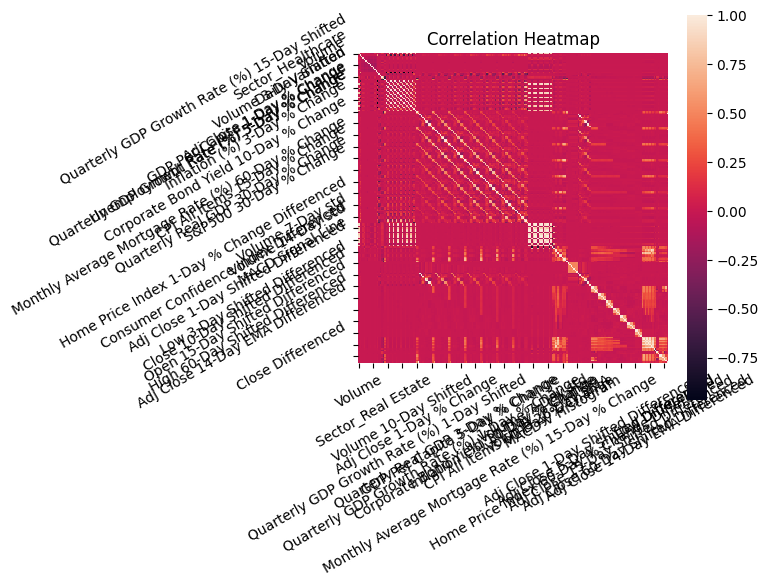

In [8]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [9]:
# Get columns of correlation matrix that have high correlation to other features (need upper triangular matrix to stop wrong features being dropped)
correlation_threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in list(upper.columns) if any(upper[column] > correlation_threshold)]
print(to_drop)  

['Unemployment Rate (%) 3-Day Shifted', 'Quarterly GDP Growth Rate (%) 3-Day Shifted', 'Unemployment Rate (%) 5-Day Shifted', 'Quarterly GDP Growth Rate (%) 5-Day Shifted', 'Unemployment Rate (%) 10-Day Shifted', 'Quarterly GDP Growth Rate (%) 10-Day Shifted', 'Unemployment Rate (%) 15-Day Shifted', 'Quarterly GDP Growth Rate (%) 15-Day Shifted', 'Unemployment Rate (%) 30-Day Shifted', 'Unemployment Rate (%) 60-Day Shifted', 'Quarterly Real GDP 1-Day % Change', 'Quarterly Real GDP 3-Day % Change', 'Quarterly Real GDP 5-Day % Change', 'Quarterly Real GDP 10-Day % Change', 'Quarterly Real GDP 15-Day % Change', 'Quarterly Real GDP 30-Day % Change', 'Volume 7-Day SMA', 'Volume 7-Day EMA', 'Volume 12-Day SMA', 'Volume 12-Day EMA', 'Adj Close 12-Day std', 'Volume 12-Day std', 'Volume 14-Day SMA', 'Volume 14-Day EMA', 'Adj Close 14-Day std', 'Volume 14-Day std', 'Volume 26-Day SMA', 'Volume 26-Day EMA', 'Adj Close 26-Day std', 'Volume 26-Day std', 'MACD Signal Line', 'MACD-V Signal Line', 'St

In [10]:
# Drop highly correlated features from X_train and X_test
X_train_normalized.drop(to_drop, axis=1, inplace=True)
X_test_normalized.drop(to_drop, axis=1, inplace=True)

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

X_train_normalized: (628531, 159)
X_test_normalized: (154301, 159)


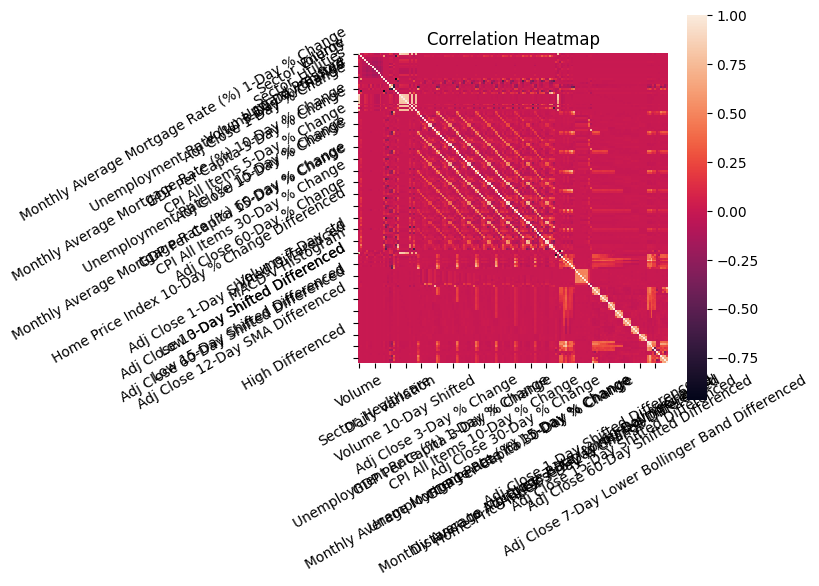

In [11]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

## Wrapper Methods

Wrapper methods eliminate features by looking at weights/coefficients of features in a trained model. In this case we use CatBoost's built-in method select_features(). This selects a subset of features based on their SHAP (SHapely Additive exPlanations) values, which measure their contribution to the final outcome.

In [12]:
# Get training and eval set to use while selecting features
from sklearn.model_selection import train_test_split
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_train_normalized, 
    y_train, 
    test_size=0.20, 
    shuffle=False
)

# Print shapes
print(f"X_train_cb: {X_train_cb.shape}")
print(f"y_train_cb: {y_train_cb.shape}")
print(f"X_val_cb: {X_val_cb.shape}")
print(f"y_val_cb: {y_val_cb.shape}")

X_train_cb: (502824, 159)
y_train_cb: (502824,)
X_val_cb: (125707, 159)
y_val_cb: (125707,)


In [13]:
# Get training and validation pools
from catboost import Pool
feature_names = list(X_train_cb.columns)
train_pool = Pool(X_train_cb, y_train_cb, feature_names=feature_names)
val_pool = Pool(X_val_cb, y_val_cb, feature_names=feature_names)

# Build CatBoost model
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=25000,
    learning_rate=0.01,
    early_stopping_rounds=250,
    loss_function='Logloss'
)

In [14]:
# Select best features
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
summary = model.select_features(
    X=train_pool,
    eval_set=val_pool,
    features_for_select=f'0-{len(feature_names) - 1}',
    num_features_to_select=int(0.7*len(feature_names)),
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Verbose",
    plot=True
)
print(summary)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 10
0:	learn: 0.6924025	test: 0.6927342	best: 0.6927342 (0)	total: 354ms	remaining: 2h 27m 22s
1:	learn: 0.6916879	test: 0.6925146	best: 0.6925146 (1)	total: 609ms	remaining: 2h 6m 52s
2:	learn: 0.6910421	test: 0.6923434	best: 0.6923434 (2)	total: 832ms	remaining: 1h 55m 28s
3:	learn: 0.6904807	test: 0.6919663	best: 0.6919663 (3)	total: 1.08s	remaining: 1h 52m 47s
4:	learn: 0.6899252	test: 0.6914989	best: 0.6914989 (4)	total: 1.39s	remaining: 1h 55m 38s
5:	learn: 0.6892301	test: 0.6910113	best: 0.6910113 (5)	total: 1.65s	remaining: 1h 54m 25s
6:	learn: 0.6886570	test: 0.6908557	best: 0.6908557 (6)	total: 1.92s	remaining: 1h 54m 2s
7:	learn: 0.6881086	test: 0.6906897	best: 0.6906897 (7)	total: 2.13s	remaining: 1h 50m 47s
8:	learn: 0.6874816	test: 0.6904170	best: 0.6904170 (8)	total: 2.36s	remaining: 1h 49m 11s
9:	learn: 0.6868927	test: 0.6901741	best: 0.6901741 (9)	total: 2.61s	remaining: 1h 48m 39s
10:	learn: 0.6863552	test: 0.6899205	best: 0.6899205 (10)	total: 2.86s	rem

{'selected_features': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 44, 45, 47, 48, 49, 55, 59, 63, 64, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 94, 97, 98, 99, 100, 101, 102, 103, 105, 107, 110, 111, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 151, 153, 154, 155, 156, 157, 158], 'eliminated_features_names': ['S&P500 10-Day % Change', 'Quarterly GDP Growth Rate (%) 30-Day Shifted', 'S&P500 15-Day % Change', 'S&P500 5-Day % Change', 'Unemployment Rate (%) 5-Day % Change', 'S&P500 60-Day % Change', 'Monthly Average Mortgage Rate (%) 5-Day % Change', 'S&P500 3-Day % Change', 'Unemployment Rate (%) 60-Day % Change', 'Inflation (%) 60-Day % Change', 'S&P500 1-Day % Change', 'Consumer Confidence Index 15-Day % Change', 'Monthly Average Mortgage Rate (%) 10-Day % Change', '

In [15]:
# Drop unwanted features from dataframes
X_train_normalized = X_train_normalized[summary['selected_features_names']]
X_test_normalized = X_test_normalized[summary['selected_features_names']]

# Add back Date and Symbol columns
X_train_normalized[['Date', 'Symbol']] = X_train[['Date', 'Symbol']].reset_index(drop=True)
X_test_normalized[['Date', 'Symbol']] = X_test[['Date', 'Symbol']].reset_index(drop=True)

In [16]:
X_train_normalized

,Volume,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,...,Open 60-Day Shifted Differenced,Adj Close 7-Day Upper Bollinger Band Differenced,True Range Differenced,True Range 26-Day SMA Differenced,Adj Close Differenced,High Differenced,Low Differenced,Open Differenced,Date,Symbol
0,-0.082146,-0.211123,-0.211123,-0.355936,-0.279668,4.506073,-0.394063,-0.386806,-0.411949,-0.256814,...,-0.099365,-0.065462,0.021662,0.207475,-0.143825,0.001395,-0.216950,-0.124697,2014-09-04,14
1,-0.199298,-0.211123,-0.211123,-0.355936,-0.279668,4.506073,-0.394063,-0.386806,-0.411949,-0.256814,...,0.128093,-0.026616,-0.135444,0.292787,-0.199996,-0.087753,-0.355281,-0.261008,2014-09-04,262
2,0.256066,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,-0.127797,-0.051266,-0.014738,0.014914,0.041423,-0.083876,-0.089539,-0.100843,2014-09-04,105
3,0.809517,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,2.537663,-0.386806,-0.411949,-0.256814,...,0.163632,0.078857,0.052865,0.340484,0.049223,0.117676,0.048791,-0.012241,2014-09-04,395
4,-0.205682,-0.211123,-0.211123,2.809494,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,0.106768,-0.007671,-0.240677,-0.105232,-0.049846,-0.320311,-0.064057,-0.346203,2014-09-04,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628526,-0.106601,-0.211123,-0.211123,-0.355936,-0.279668,4.506073,-0.394063,-0.386806,-0.411949,-0.256814,...,0.248928,-0.112632,0.087153,0.078766,0.108860,-0.048993,-0.246072,-0.329163,2019-12-31,365
628527,0.010060,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,0.039166,-0.023366,-0.010786,0.076045,0.028035,-0.037338,-0.032313,-0.018079,2019-12-31,303
628528,-0.367063,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,2.427487,-0.256814,...,1.336451,-0.455647,-0.071207,0.504422,0.073186,0.191322,0.056076,-0.250786,2019-12-31,268
628529,-0.279366,-0.211123,-0.211123,-0.355936,3.575666,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,0.103214,-0.035176,0.020092,0.008873,0.009616,0.013023,0.012388,-0.008833,2019-12-31,223


In [17]:
X_test_normalized

,Volume,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,Sector_Industrials,Sector_Real Estate,...,Open 60-Day Shifted Differenced,Adj Close 7-Day Upper Bollinger Band Differenced,True Range Differenced,True Range 26-Day SMA Differenced,Adj Close Differenced,High Differenced,Low Differenced,Open Differenced,Date,Symbol
0,-0.263726,-0.211123,4.736577,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,-0.181107,-0.262042,-0.154274,-1.323139,-0.492231,-0.014108,-0.377124,0.161556,2021-01-04,139
1,-0.186121,-0.211123,-0.211123,-0.355936,3.575666,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,-0.216647,-0.008371,-0.027088,-0.381858,-0.122099,0.016899,-0.064058,0.035468,2021-01-04,255
2,-0.309133,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,2.537663,-0.386806,-0.411949,-0.256814,...,-0.778181,-0.134680,-0.002115,-0.513907,-0.962961,0.303723,-0.621021,0.386469,2021-01-04,378
3,-0.225167,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,2.427487,-0.256814,...,0.348439,-0.106183,-0.067764,-0.330715,-0.801156,0.156436,-0.497253,0.076363,2021-01-04,141
4,0.330085,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,3.893864,...,-0.056716,-0.115870,0.046599,-0.063529,-0.173969,0.040155,-0.140504,0.015022,2021-01-04,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154296,-0.283036,-0.211123,-0.211123,2.809494,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,-1.055393,0.058431,-0.238243,-0.572256,-0.185392,-0.351320,-0.318879,-0.281454,2022-04-22,266
154297,0.928227,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,2.537663,-0.386806,-0.411949,-0.256814,...,0.067674,-0.025965,-0.160179,-0.117694,-0.127517,-0.235040,-0.133224,-0.066765,2022-04-22,265
154298,-0.199040,-0.211123,4.736577,-0.355936,-0.279668,-0.221923,-0.394063,-0.386806,-0.411949,-0.256814,...,0.025026,-0.009026,-0.099396,-0.020485,-0.192856,-0.359072,-0.227871,-0.298494,2022-04-22,144
154299,-0.306397,-0.211123,-0.211123,-0.355936,-0.279668,-0.221923,-0.394063,2.585277,-0.411949,-0.256814,...,0.142303,1.379800,-0.645926,-0.108369,-2.881441,-4.258316,-2.732395,-3.839172,2022-04-22,238


## Write outputs

In [18]:
# Training set, test set and selected features
X_train_normalized.to_csv(path_or_buf="X_train_normalized.csv")
X_test_normalized.to_csv(path_or_buf="X_test_normalized.csv")
y_train.to_csv(path_or_buf="y_train.csv")
y_test.to_csv(path_or_buf="y_test.csv")